In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs

In [2]:
training = ClassificationTraining()
analysis = ClassificationAnalysis()

results = training.load_training_models()
indices = analysis.load_performance_indices()

[1, 3, 5, 7, 9, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


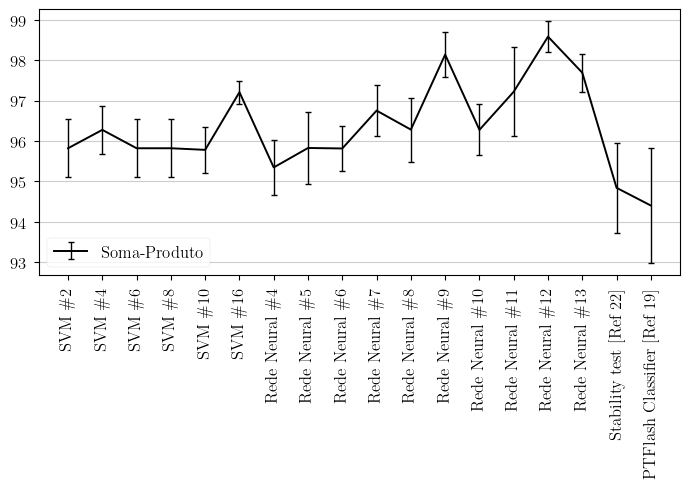

In [7]:
name = "sp_index"
# models = [i for i in range(19, 34)]
models = [1, 3, 5, 7, 9, 15] + [i for i in range(19, len(results["outputs"]))]
print(models)

outputs = [output for i, output in enumerate(results["outputs"]) if i in models]
labels = [hp["model_name"].replace("#", "\#") for hp in outputs]
x = np.array([i + 1 for i in np.arange(len(outputs))])

f, ax = plt.subplots(figsize=(7, 5))

y = indices[name][:, models].mean(axis=0) * 100
y_err = (indices[name][:, models].std(axis=0) / np.sqrt(10 - 1)) * 100
ax.errorbar(x, y, y_err, label="Soma-Produto", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower left")

f.tight_layout()
f.savefig(os.path.join("data", "images", f"{name}_errorbar_plot_alt.png"), dpi=600)

In [10]:
# Rede Neural #9 - Id: 24
# Rede Neural #11 - Id: 26
# Rede Neural #12 - Id: 27
#
# Wilcoxon test
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples
# come from the same distribution. In particular, it tests whether the distribution of the
# differences x - y is symmetric about zero. It is a non-parametric version of the paired
# T-test.
#
#   - alternative='two-sided': the distribution underlying d is not symmetric about zero.

from scipy import stats


def wilcoxon_test(sample1: np.ndarray, sample2: np.ndarray):
    d = np.around(sample1 - sample2, decimals=3)
    return stats.wilcoxon(d, alternative="two-sided")


print(wilcoxon_test(indices["sp_index"][:, 24], indices["sp_index"][:, 26]))
print(wilcoxon_test(indices["sp_index"][:, 24], indices["sp_index"][:, 27]))

WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)


d:\git\nn-flash\.venv\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


## Confusion Matrix

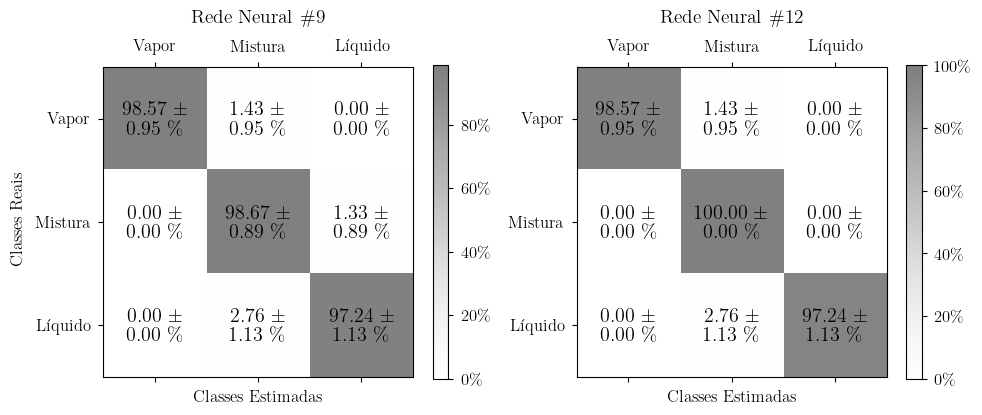

In [11]:
from matplotlib import ticker

models = [24, 27]
outputs = [output for i, output in enumerate(results["outputs"]) if i in models]
model_names = [res["model_name"].replace("#", "\#") for res in outputs]

f, axs = plt.subplots(1, len(models), figsize=(5 * len(models), 5))
for i, (model_info, ax) in enumerate(zip(results["outputs"], axs)):
    model_type = model_info["model_type"]
    model_id = model_info["model_id"]

    cm = indices["confusion_matrix"][:, models[i], :, :].astype("int16")

    cm = cm / np.sum(cm, axis=2)[:, :, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0) / np.sqrt(10 - 1)

    ms = ax.matshow(cm_mean, alpha=0.5, cmap="Greys")
    for ii in range(cm_mean.shape[0]):
        for jj in range(cm_mean.shape[1]):
            text = f"{cm_mean[ii, jj] * 100:1.2f} \\textpm \n {cm_std[ii, jj] * 100:1.2f} \%"
            ax.text(x=jj, y=ii, s=text, va="center", ha="center", size="x-large")

    cbar = ax.figure.colorbar(ms, ax=ax, shrink=0.675, format=ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Classes Estimadas")
    # ax.set_ylabel("Classes Reais")
    ax.set_title(model_names[i])

    # 0: gas, 1: mix, 2: oil
    ax.set_xticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.set_yticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.grid(False)

f.supylabel("Classes Reais")
f.tight_layout()

plt.savefig(os.path.join("data", "images", "comparing_confusion_matrices.png"), dpi=600)
plt.show()